# OpenAI Gym

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import jax.numpy as jnp

import gymnasium as gym

from extravaganza.dynamical_systems import Gym

from extravaganza.lifters import NoLift, RandomLift, LearnedLift
from extravaganza.sysid import SysID
from extravaganza.controllers import LiftedBPC, ConstantController
from extravaganza.rescalers import ADAM, D_ADAM, DoWG
from experiments import run_experiment, ylim

# seeds for randomness. setting to `None` uses random seeds
SYSTEM_SEED = None
CONTROLLER_SEED = None
LIFTER_AND_SYSID_SEED = None

## System
Here, we work with games in the OpenAI gym, such as `MountainCarContinuous-v0`, in which we supply a value in `[-1, 1]` as a control to push a car left or right up a mountain. The tricky thing about this environment is that you first have to push the car up the left to gain momentum, even though the goal is on the right.

Another good environment is the `CartPole` enviroment (left and right bumps on a cart to keep an inverted pendulum upright), whose continuous analog is also displayed below.

We make use of **only the reward signal or cost function** to train, not using any state observation.

In [2]:
"""
DISPLAY DA TINGZ HERE
""";

## Hyperparameters

In [3]:
# --------------------------------------------------------------------------------------
# ------------------------    EXPERIMENT HYPERPARAMETERS    ----------------------------
# --------------------------------------------------------------------------------------

num_trials = 1
T = 20000  # total timesteps
T0 = 6000  # number of timesteps to just sysid for our methods
reset_every = 1000  # how often to reset the system
wordy = True  # whether to print some things

# --------------------------------------------------------------------------------------
# --------------------------    SYSTEM HYPERPARAMETERS    ------------------------------
# --------------------------------------------------------------------------------------

env_name = 'CartPoleContinuous-v1'  
# env_name = 'MountainCarContinuous-v0'
repeat = 4  # how many times to repeat each action before a new one can be chosen
render = False

make_system = lambda : Gym(env_name, repeat, render, seed=SYSTEM_SEED)
du = make_system().control_dim

# --------------------------------------------------------------------------------------
# ------------------------    LIFT/SYSID HYPERPARAMETERS    ----------------------------
# --------------------------------------------------------------------------------------

sysid_method = 'regression'
sysid_scale = 1.0

learned_lift_args = {
    'lift_lr': 0.01,
    'sysid_lr': 0.01,
    'cost_lr': 0.001,
    'depth': 6,
    'buffer_maxlen': int(1e6),
    'num_epochs': 75,
    'batch_size': 64,
    'seed': LIFTER_AND_SYSID_SEED
}

# --------------------------------------------------------------------------------------
# ------------------------    CONTROLLER HYPERPARAMETERS    ----------------------------
# --------------------------------------------------------------------------------------

h = 10  # controller memory length (# of w's to use on inference)
hh = 10  # history length of the cost/control histories
lift_dim = 20  # dimension to lift to

m_update_rescaler = lambda : ADAM(0.003, betas=(0.9, 0.999))
m0_update_rescaler = lambda : ADAM(0.00, betas=(0.9, 0.999))
k_update_rescaler = lambda : ADAM(0.00, betas=(0.9, 0.999))

lifted_bpc_args = {
    'h': h,
    'method': 'REINFORCE',
    'initial_scales': (0.1, 0.1, 0.0),  # M, M0, K   (uses M0's scale for REINFORCE)
    'rescalers': (m_update_rescaler, m0_update_rescaler, k_update_rescaler),
    'T0': T0,
#     'bounds': (-1, 1),
    'initial_u': jnp.zeros(du),
    'decay_scales': False,
    'use_tanh': False,
    'use_K_from_sysid': False,
    'seed': CONTROLLER_SEED
}

make_controllers = {
#     'Zero': lambda sys: ConstantController(0, du),
#     'No Lift': lambda sys: LiftedBPC(lifter=NoLift(hh, du, LIFTER_AND_SYSID_SEED), sysid=SysID(sysid_method, du, hh, sysid_scale, LIFTER_AND_SYSID_SEED), **lifted_bpc_args),
#     'Random Lift': lambda sys: LiftedBPC(lifter=RandomLift(hh, du, lift_dim, learned_lift_args['depth'], LIFTER_AND_SYSID_SEED), sysid=SysID(sysid_method, du, lift_dim, sysid_scale, LIFTER_AND_SYSID_SEED), **lifted_bpc_args),
    'Learned Lift': lambda sys: LiftedBPC(lifter=LearnedLift(hh, du, lift_dim, scale=sysid_scale, **learned_lift_args), **lifted_bpc_args)
}

registering running average of fs
registering running average of rewards


/Users/evandigiorno/Desktop/extravaganza/env/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


## Plotting
We keep track of the useful information through `Stats` objects, which can `register()` a variable to keep track of (which it does via calls to `update()`) and which can be aggregated via `Stats.aggregate()` for mean and variance statistics. 

We define below a plotting arrangement that plots all the desired quantities from both the system and controller.

In [4]:
def plot_gym(all_stats):
    plt.clf()
    n = 5
    nrows = n + (len(all_stats) + 1) // 2
    fig, ax = plt.subplots(nrows, 2, figsize=(16, 6 * nrows))

    for i, (method, stats) in enumerate(all_stats.items()):
        if stats is None: 
            print('WARNING: {} had no stats'.format(method))
            continue
        stats.plot(ax[0, 0], 'xs', label=method)
#         stats.plot(ax[0, 1], 'ws', label=method)
        stats.plot(ax[1, 0], 'us', label=method)
#         stats.plot(ax[1, 1], 'rewards', label=method)
        stats.plot(ax[1, 1], 'avg fs', label=method)
        stats.plot(ax[2, 0], 'rewards', label=method)
        stats.plot(ax[2, 1], 'avg rewards', label=method)
    
        stats.plot(ax[3, 0], '||A||_op', label=method)
        stats.plot(ax[3, 1], '||B||_F', label=method)
        stats.plot(ax[4, 0], '||A-BK||_op', label=method)
        stats.plot(ax[4, 1], 'lifter losses', label=method)
        i_ax = ax[n + i // 2, i % 2]
        stats.plot(ax[0, 1], 'disturbances', label=method)
        stats.plot(i_ax, 'K @ state', label='K @ state')
        stats.plot(i_ax, 'M \cdot w', label='M \cdot w')
        stats.plot(i_ax, 'M0', label='M0')
        i_ax.set_title('u decomp for {}'.format(method))
        i_ax.legend()

    # set titles and legends and limits and such
    # (note: `ylim()` is so useful! because sometimes one thing blows up and then autoscale messes up all plots)
    _ax = ax[0, 0]; _ax.set_title('position'); _ax.legend(); ylim(_ax, -5, 20)
    _ax = ax[0, 1]; _ax.set_title('disturbances'); _ax.legend(); ylim(_ax, -5, 5)
    _ax = ax[1, 0]; _ax.set_title('controls'); _ax.legend(); ylim(_ax, -3, 3)
    _ax = ax[1, 1]; _ax.set_title('avg costs'); _ax.legend()
    
    _ax = ax[2, 0]; _ax.set_title('instantaneous rewards'); _ax.legend()
    _ax = ax[2, 1]; _ax.set_title('avg rewards'); _ax.legend()
    
    _ax = ax[3, 0]; _ax.set_title('||A||_op'); _ax.legend()
    _ax = ax[3, 1]; _ax.set_title('||B||_F'); _ax.legend()
    
    _ax = ax[4, 0]; _ax.set_title('||A-BK||_op'); _ax.legend()
    _ax = ax[4, 1]; _ax.set_title('lifter losses'); _ax.legend()
    pass

## actually run the thing :)

--------------------------------------------------
----------------- TRIAL 0 -----------------------
--------------------------------------------------

testing Learned Lift
registering running average of fs
registering running average of rewards
registering running average of costs


  0%|                                                                                                                | 0/20000 [00:00<?, ?it/s]

reset!


  5%|███▋                                                                 | 1065/20000 [00:03<00:57, 330.53it/s, control=0.0507, cost=0.000668]

reset!


 10%|███████▎                                                                | 2030/20000 [00:07<01:06, 271.29it/s, control=0.931, cost=0.0819]

reset!


 15%|██████████▊                                                            | 3039/20000 [00:10<01:02, 273.29it/s, control=-.18, cost=0.000602]

reset!


 20%|██████████████▌                                                         | 4043/20000 [00:14<00:58, 271.03it/s, control=-.371, cost=0.0455]

reset!


 25%|█████████████████▋                                                    | 5048/20000 [00:18<00:56, 263.47it/s, control=0.258, cost=0.000635]

reset!


 30%|████████████████████▉                                                 | 5985/20000 [00:21<00:53, 260.73it/s, control=0.148, cost=0.000164]

training!
mean loss for past 25 epochs was 0.009686382785439492
mean loss for past 25 epochs was 0.000475394498789683
mean loss for past 25 epochs was 0.0005488657904788852


 30%|████████████████████▉                                                 | 5985/20000 [00:40<00:53, 260.73it/s, control=0.148, cost=0.000164]

mean loss for past 25 epochs was 0.0005517234106082469
||A||_op = 1.0765645503997803     ||B||_F 0.0036313594318926334


 30%|█████████████████████                                                 | 6006/20000 [00:46<1:07:49,  3.44it/s, control=-.0888, cost=0.0493]

reset!


 35%|█████████████████████████▌                                               | 7008/20000 [01:02<03:36, 60.04it/s, control=-.0601, cost=0.014]

reset!


 40%|████████████████████████████▍                                          | 8008/20000 [01:19<03:09, 63.25it/s, control=0.0413, cost=0.00508]

reset!


 45%|███████████████████████████████▉                                       | 9009/20000 [01:34<02:52, 63.66it/s, control=-.0756, cost=0.00154]

reset!


 50%|███████████████████████████████████▌                                   | 10010/20000 [01:50<02:38, 63.04it/s, control=-.0608, cost=0.0126]

reset!


 55%|██████████████████████████████████████▌                               | 11014/20000 [02:06<02:08, 69.86it/s, control=0.0165, cost=0.00445]

reset!


 60%|██████████████████████████████████████████▋                            | 12013/20000 [02:21<01:59, 66.66it/s, control=0.0332, cost=0.0471]

reset!


 65%|██████████████████████████████████████████████▏                        | 13008/20000 [02:36<01:45, 66.27it/s, control=-.0634, cost=0.0147]

reset!


 70%|█████████████████████████████████████████████████                     | 14009/20000 [02:52<01:36, 62.04it/s, control=-.00735, cost=0.0146]

reset!


 75%|████████████████████████████████████████████████████▌                 | 15009/20000 [03:08<01:20, 62.28it/s, control=0.0691, cost=0.00402]

reset!


 80%|████████████████████████████████████████████████████████              | 16010/20000 [03:24<01:04, 61.71it/s, control=0.0222, cost=0.00748]

reset!


 85%|███████████████████████████████████████████████████████████▌          | 17011/20000 [03:41<00:48, 61.22it/s, control=0.0962, cost=0.00126]

reset!


 90%|███████████████████████████████████████████████████████████████       | 18008/20000 [03:57<00:32, 60.87it/s, control=0.0465, cost=0.00753]

reset!


 95%|██████████████████████████████████████████████████████████████████▌   | 19011/20000 [04:13<00:16, 59.86it/s, control=0.0857, cost=0.00376]

reset!


100%|██████████████████████████████████████████████████████████████████████| 20000/20000 [04:30<00:00, 73.96it/s, control=-.0468, cost=0.00147]


<Figure size 640x480 with 0 Axes>

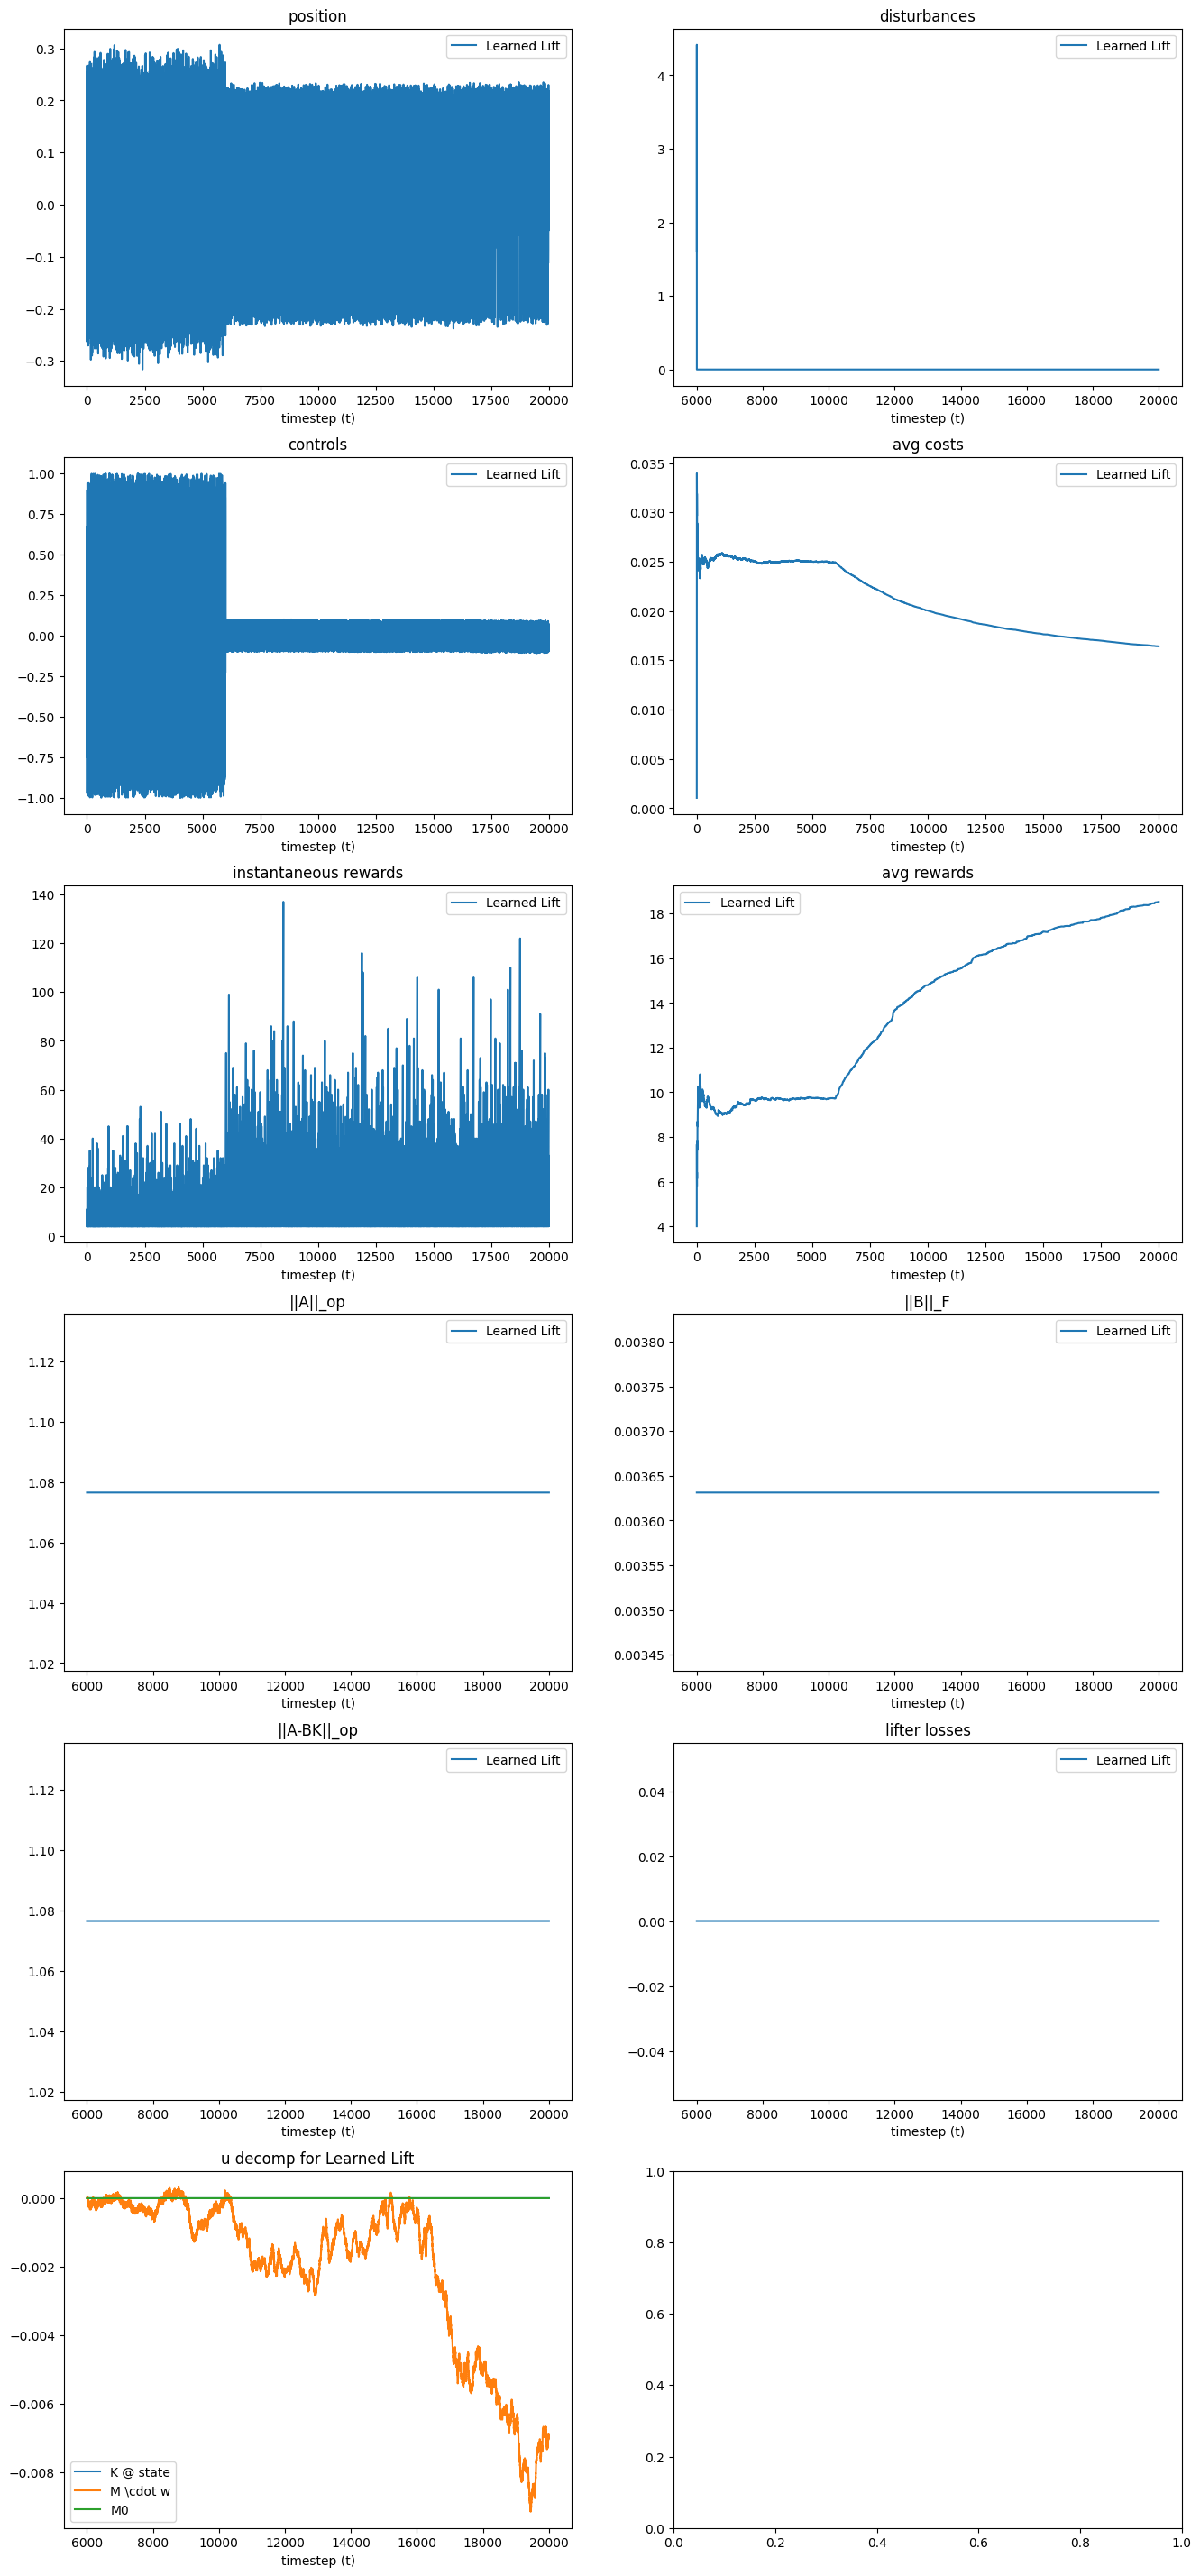

In [5]:
experiment_args = {
    'make_system': make_system,
    'make_controllers': make_controllers,
    'num_trials': num_trials,
    'T': T,
    'reset_every': reset_every,
    'reset_seed': SYSTEM_SEED,
    'wordy': wordy,
    
}
stats = run_experiment(**experiment_args)
plot_gym(stats)
# plot_gym({l: s[6000:6100] for l, s in stats.items()})